#**Scene Recognition Using Neural Networks**

in this notebook we want to train cnn models with different architectures .

* PART 1 : `using first convolutional layer and two last fully connected layer of Alexnet architecture .` note that we use `max_pooling` layer with `kernel_size=4` and `stride=4` in first layer .


---


* PART 2 : `using three first convolutions layer and three last fully connected layer of Alexnet architecture` . in the `third  layer` , we change the conv2d layer with depth of 384 to 256 .` 


---


* PART 3 : using `whole Alexnet architecture` and just change the last fully_connected layer with depth of 1000 to 15 but `without any pre_trained weights.` more specifically , we don't use pre_trained parameters that derived for architecture from imagenet dataset .    


---



* PART 4 : using `whole Alexnet architecture` and just change the last fully_connected layer with depth of 1000 to 15  . we `use pre_trained weights` for all the layers expect for new classifer layer .during training ,  `we just let the parameters of new classifier layer to update` in each epoch and freeze all other parameters.

---



* PART 5 : using `whole Alexnet architecture` and just change the last fully_connected layer with depth of 1000 to 15  . we `use pre_trained weights` for all the layers expect for new classifier layer .during training ,  we `let all parameters of all layers to update in each epoch .` 


##**import required libraries**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
import torch.utils.data as data
import os
import zipfile
import matplotlib.pyplot as plt 

##**use gpu if it's available**

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##**configuration**

below we determine hyper-parameters of our cnn model and root of train/test set

* `batch_size` : set to `128` because for greater value the less update we have for the weights (doesn't converge well) and for smaller value we lost the generality of the model (the gradient is not trust-able)

* `learning rate ` : set to `0.001` and gradually decrease in next epoch 

* `num_classes ` : set to `15` because our classification problem has 15 class 

* `epoches ` : number of epoches set to  `50` for this problem 

* `num_workers ` : indicate how multi_processing we have in each batch . is set it to `1` 

* `train_data_path` : path of extracted train data that we have pass to `torchvision.datasets.ImageFolder`  

* `test_data_path` : path of extracted test data that we have pass to `torchvision.datasets.ImageFolder`  





In [ ]:
config = {
    '''
    note that all files are saved in folders.
    Pictures of the same category are stored in each folder. 
    The folder name is class name

    '''

    'extracted_root' : "/content/Data", #path of extracted zip data
    'train_data_path' : "/content/Data/Train" , #path of extracted train data 
    'test_data_path' : "/content/Data/Test" ,  # path of extracted test data 
    'batch_size' : 64 , 
    'num_workers' : 1 ,
    'num_classes' : 15 ,
    'eopches' : 50 ,
    'learning_rate' : 0.0005
}

##**clone drive**

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##**unzip dataset**

In [ ]:
os.chdir("/content")
path_of_zip_file="/content/gdrive/MyDrive/vision_dataset/Data.zip"

with zipfile.ZipFile(path_of_zip_file, 'r') as zip_ref:
      zip_ref.extractall("/content")

##**define transform for training and test set**
in this section we set different transforms for training and test set

* training set : for this , we define 4 different transform in a sequential structure . 

1. resize each image (`transforms.Resize`) to `227×227`

2. augment training set using `transforms.RandomHorizontalFlip` to mirror each image horizontally  . note that because our objective is  `scene recognition ` , many of transforms like rotating , mirror vertically and ... lead to bad training and bad dataset . so we only use `transforms.RandomVerticalFlip`. we set the p(probability) to 1 to have one new training dataset alongside the original training dataset

3. convert dataset to tensor 

4. normalize dataset based on alexnet mean and std 



* test set : all of test_set transforms are like training_set transforms except that we don't need augmentation in test_set



In [ ]:
#define normalization transform 
normalize = transforms.Normalize(                          
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],)


#define train_set transform 
train_transform1 = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,])

#--------------------------

train_transform2 = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor(),
            normalize,])
# #---------------------------

#define test_set transform 
test_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,])

##**split data augmentation**
one good way to split data and pass it to `dataloader` is to use `torchvision.datasets.ImageFolder` . this function get images with their label without using any label file . `Imagefolder` assumes that all files are saved in folders ,Pictures of the same category are stored in each folder and The folder name is class name .

 we also use `torch.utils.data.ConcatDataset` for concatenating the new training dataset created by `transforms.RandomHorizontalFlip(p=1)` with original training dataset


In [ ]:
#---trainig set
all_datasets = []
train_data_aug1 = torchvision.datasets.ImageFolder(root=config['train_data_path'], transform=train_transform1)
all_datasets.append(train_data_aug1)
train_data_aug2 = torchvision.datasets.ImageFolder(root=config['train_data_path'], transform=train_transform2)
all_datasets.append(train_data_aug2)

train_data_total = torch.utils.data.ConcatDataset(all_datasets)
train_data_loader  = data.DataLoader(train_data_total, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers']) 

#---test set 
test_data = torchvision.datasets.ImageFolder(root=config['test_data_path'], transform=test_transform)
test_data_loader  = data.DataLoader(test_data, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers']) 

length of train dataset before and after augmentation

In [ ]:
print(f"length of train_set before augmentation :  {len(train_data_aug1)}")
print(f"length of train_set after augmentation : {len(train_data_total)}")


length of train_set before augmentation 2985
length of train_set after augmentation 5970


##**define funtions**

* measure accuracy

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.reshape(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

* train and evaluate the accuracy/loss in each epoch

In [ ]:
def train_model(model):

    total_step_test = len(test_data_loader)                    #------------------------------------
    total_step_train = len(train_data_loader)                  #----------    train   --------------
                                                               #------------------------------------                                        
    loss_train=[]
    acc1_train=[]
    acc5_train=[]
    #-----------------
    loss_test=[]
    acc1_test=[]
    acc5_test=[]

    
    for epoch in range(config['eopches']):
        
        
        sum_of_loss=0
        sum_acc1=0
        sum_acc5=0
        
        for i, (images, labels) in enumerate(train_data_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            #--Forward pass
            outputs = model(images)
            #----measure acc
            acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
            sum_acc1+=float(acc1)
            sum_acc5+=float(acc5)
            #----measure loss 
            loss = criterion(outputs, labels)
            sum_of_loss+=float(loss)
            #----Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_of_each_epoch=float(sum_of_loss/total_step_train)

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                      .format(epoch+1, config['eopches'], i+1, total_step_train ,loss_of_each_epoch))
        
        print('Acc@1 of train_set: {} %'.format(sum_acc1 / total_step_train )) 

        
        loss_train.append(loss_of_each_epoch)
        acc1_train.append(sum_acc1 / total_step_train)
        acc5_train.append(sum_acc5 / total_step_train)

            
        # measure acc on test_set                #-------------------------------------
                                                 #-------------  test  ----------------
        with torch.no_grad():                    #-------------------------------------

            sum_acc1=0
            sum_acc5=0
            sum_of_loss=0

            for i,(images, labels) in  enumerate(test_data_loader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)

                # measure loss 
                loss = criterion(outputs, labels)
                sum_of_loss+=float(loss)

                # measure acc
                acc1, acc5 = accuracy(outputs, labels, topk=(1, 5))
                sum_acc1+=float(acc1)
                sum_acc5+=float(acc5)

                del images, labels, outputs
            loss_of_each_epoch=float(sum_of_loss/total_step_test)

            loss_test.append(loss_of_each_epoch)
            acc1_test.append(sum_acc1 / total_step_test)
            acc5_test.append(sum_acc5 / total_step_test)
            
            print('Acc@1 of validation_set: {} %'.format(sum_acc1 / total_step_test )) 
            print('------------------------------') 

 

    return loss_test,acc1_test,acc5_test,loss_train,acc1_train,acc5_train

* plot function for acc@1 , acc@5 and loss with respect to epoches

In [ ]:
def acc_loss_plot(loss_test,acc1_test,acc5_test,loss_train,acc1_train,acc5_train):
    #define horizental axis
    x_axis=np.array([i for i in np.arange(1,51)])
    
    #---plot loss function for train and test set in each epoch
    plt.plot(x_axis, loss_train,label="trian loss")
    plt.plot(x_axis, loss_test,label="test loss")
    plt.legend(loc="upper right")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("loss on train and test set")
    plt.show()
    #--------------------------------

    #---plot acc@1 for train and test set in each epoch
    plt.plot(x_axis, acc1_train,label="trian accuracy")
    plt.plot(x_axis, acc1_test,label="test accuracy")
    plt.legend(loc="upper left")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("acc@1 on train and test set")
    
    plt.show()

    #---plot acc@5 for train and test set in each epoch
    plt.plot(x_axis, acc5_train,label="trian accuracy")
    plt.plot(x_axis, acc5_test,label="test accuracy")
    plt.legend(loc="upper left")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("acc@5 on train and test set")
    
    plt.show()

##**alexnet architecture**

<tr>
<td> <img src="https://miro.medium.com/max/1400/0*tp3-vrF9PiK3qtsk.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://www.datasciencecentral.com/wp-content/uploads/2021/10/2808365162.jpeg" alt="Drawing" style="width: 250px;"/> </td>
</tr>


###**part 1**
`using first convolutional layer and two last fully connected layer of Alexnet architecture .` note that we use `max_pooling` layer with `kernel_size=4` and `stride=4` in first layer .

*  we also add new layer
`LocalResponseNorm(2)`  .`this operation helps us to reduce input image noises`  

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            # nn.BatchNorm2d(96),
            nn.LocalResponseNorm(2), #adding new additional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16224, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

###**load model and optimizer**

In [ ]:
#load the model
model = AlexNet(config['num_classes']).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)  

###**train the model**

In [ ]:
loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr=train_model(model)

Epoch [1/50], Step [94/94], Loss: 2.4408
Acc@1 of train_set: 21.579491716750123 %
Acc@1 of validation_set: 26.609002987543743 %
------------------------------
Epoch [2/50], Step [94/94], Loss: 2.0789
Acc@1 of train_set: 34.73330375996042 %
Acc@1 of validation_set: 33.658854166666664 %
------------------------------
Epoch [3/50], Step [94/94], Loss: 1.8603
Acc@1 of train_set: 41.14952716421574 %
Acc@1 of validation_set: 41.19233624140421 %
------------------------------
Epoch [4/50], Step [94/94], Loss: 1.6916
Acc@1 of train_set: 45.9164450219337 %
Acc@1 of validation_set: 40.243675549825035 %
------------------------------
Epoch [5/50], Step [94/94], Loss: 1.5250
Acc@1 of train_set: 52.16275113694211 %
Acc@1 of validation_set: 46.316964308420815 %
------------------------------
Epoch [6/50], Step [94/94], Loss: 1.3676
Acc@1 of train_set: 56.399601063829785 %
Acc@1 of validation_set: 47.24702374140421 %
------------------------------
Epoch [7/50], Step [94/94], Loss: 1.2835
Acc@1 of tra

##**plot loss and accuracy**

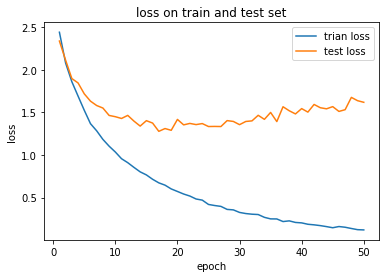

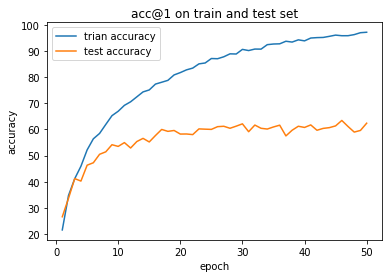

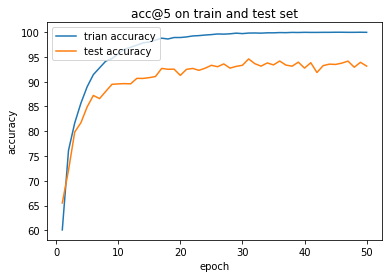

In [ ]:
acc_loss_plot(loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr)

$Results  : $

$maximum \ acc@1 \  on \  test \ set \ converges \  to  \ : \ 63.4  $%

$maximum \ acc@5 \  on \  test \ set \ converges \  to  \ : \ 93  $%


$maximum \ acc@1 \  on \  trian \ set \ converges \  to  \ : \ 100  $%

$maximum \ acc@5 \  on \  train \ set \ converges \  to  \ : \ 97.2  $%

---
$conclusions  : $

as we can see there is no overfiting in training model . there is a gap between test loss and train loss after some epoches as we expected. 
also the curve of acc@1-vs-epoch Meet our expectations because there is a gap between test's acc@1 and train's acc@1 over epoches.



###**part 2**
`using three first convolutional layer and three last fully connected layer of Alexnet arcitecture` . in the `third  layer` , we change the conv2d layer with depth of `384 to 256 .` 

* we also add new layer
`LocalResponseNorm(2)`  .`this operation helps us to reduce input image noises`  

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            # nn.BatchNorm2d(96),
            nn.LocalResponseNorm(2), #adding new additional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

###**load model**

In [ ]:
#load the model
model = AlexNet(config['num_classes']).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)  

###**train model**

In [ ]:
loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr=train_model(model)

Epoch [1/50], Step [94/94], Loss: 2.5756
Acc@1 of train_set: 15.63608155352004 %
Acc@1 of validation_set: 20.5078125 %
------------------------------
Epoch [2/50], Step [94/94], Loss: 2.2731
Acc@1 of train_set: 27.53767729820089 %
Acc@1 of validation_set: 26.255580345789593 %
------------------------------
Epoch [3/50], Step [94/94], Loss: 1.9399
Acc@1 of train_set: 38.43454490823949 %
Acc@1 of validation_set: 36.811755975087486 %
------------------------------
Epoch [4/50], Step [94/94], Loss: 1.6096
Acc@1 of train_set: 47.51588354719446 %
Acc@1 of validation_set: 44.614955266316734 %
------------------------------
Epoch [5/50], Step [94/94], Loss: 1.3664
Acc@1 of train_set: 54.77061170212766 %
Acc@1 of validation_set: 53.385416666666664 %
------------------------------
Epoch [6/50], Step [94/94], Loss: 1.2147
Acc@1 of train_set: 59.801640043867394 %
Acc@1 of validation_set: 53.450520833333336 %
------------------------------
Epoch [7/50], Step [94/94], Loss: 1.0837
Acc@1 of train_set

###**plot loss and accuracy**

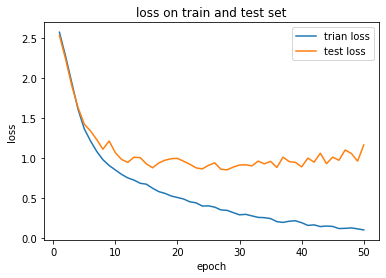

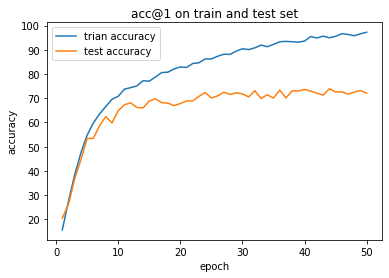

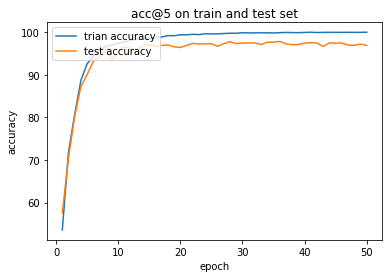

In [ ]:
acc_loss_plot(loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr)

$Results  : $


$maximum \ acc@1 \  on \  test \ set \ converges \  to  \ : \ 73.91  $%

$maximum \ acc@5 \  on \  test \ set \ converges \  to  \ : \ 93.5  $%


$maximum \ acc@1 \  on \  trian \ set \ converges \  to  \ : \ 97.27  $%

$maximum \ acc@5 \  on \  train \ set \ converges \  to  \ : \ 100  $%


---

$conclusions  : $

as we can see there is no overfiting in training model , in addition the curve of loss-vs-epoch  Meet our expectations because at first , loss of test is bigger than train and over epoches , the train loss becomes less and less but test loss becomes approximately constant after the 20th epoch . there is also a gap between test loss and train loss after some epoches. 
also the curve of acc@1-vs-epoch  Meet our expectations because there is a gap between test's acc@1 and train's acc@1 over epoches.

###**part 3**


whole alexnet arcitecture without using trained weights

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

###**load model**

In [ ]:
#load the model
model = AlexNet(config['num_classes']).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)  

###**train model**

In [ ]:
loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr=train_model(model)

Epoch [1/50], Step [94/94], Loss: 2.5389
Acc@1 of train_set: 17.17457150398417 %
Acc@1 of validation_set: 20.424107154210407 %
------------------------------
Epoch [2/50], Step [94/94], Loss: 2.0862
Acc@1 of train_set: 33.11724289427412 %
Acc@1 of validation_set: 32.72879465421041 %
------------------------------
Epoch [3/50], Step [94/94], Loss: 1.5958
Acc@1 of train_set: 47.85571808510638 %
Acc@1 of validation_set: 40.68080361684164 %
------------------------------
Epoch [4/50], Step [94/94], Loss: 1.3191
Acc@1 of train_set: 55.41334217152697 %
Acc@1 of validation_set: 50.874255975087486 %
------------------------------
Epoch [5/50], Step [94/94], Loss: 1.1364
Acc@1 of train_set: 61.737219222048495 %
Acc@1 of validation_set: 58.34263388315836 %
------------------------------
Epoch [6/50], Step [94/94], Loss: 0.9687
Acc@1 of train_set: 67.31493791620782 %
Acc@1 of validation_set: 62.75111611684164 %
------------------------------
Epoch [7/50], Step [94/94], Loss: 0.8713
Acc@1 of train

###**plot loss and accuracy**

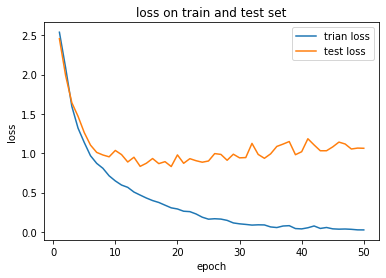

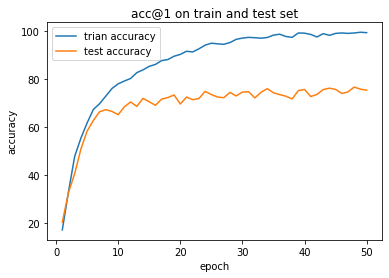

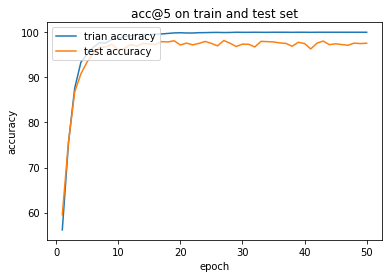

In [ ]:
acc_loss_plot(loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr)

$Results  : $

$maximum \ acc@1 \  on \  test \ set \ converges \  to  \ : \ 76.64  $%

$maximum \ acc@5 \  on \  test \ set \ converges \  to  \ : \ 96  $%


$maximum \ acc@1 \  on \  trian \ set \ converges \  to  \ : \ 99.47  $%

$maximum \ acc@5 \  on \  train \ set \ converges \  to  \ : \ 100  $%

---

$conclusions  : $

same as previous parts

###**part 4**
whole alexnet architecture : 
we squeeze the pre-trained weights ad just learn the new weight of classifier layer : 

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
#---description
AlexNet_model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

###**freeze layers before classifier**

In [ ]:
AlexNet_model.classifier[6] = nn.Linear(4096,15)
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in AlexNet_model.parameters():
        param.requires_grad = False  #freeze all layers 
for param in AlexNet_model.classifier[6].parameters():
        param.requires_grad = True   #unfreez classifer layer

###**load the model**




In [ ]:
#load the model
model = AlexNet_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum = 0.9)  

###**train model**

In [ ]:
loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr=train_model(model)

Epoch [1/50], Step [94/94], Loss: 0.8694
Acc@1 of train_set: 74.52349285369223 %
Acc@1 of validation_set: 85.1841516494751 %
------------------------------
Epoch [2/50], Step [94/94], Loss: 0.3684
Acc@1 of train_set: 89.05141838560714 %
Acc@1 of validation_set: 86.34672609965007 %
------------------------------
Epoch [3/50], Step [94/94], Loss: 0.2976
Acc@1 of train_set: 91.33791367551113 %
Acc@1 of validation_set: 86.0863094329834 %
------------------------------
Epoch [4/50], Step [94/94], Loss: 0.2561
Acc@1 of train_set: 93.01677005848985 %
Acc@1 of validation_set: 87.05357138315837 %
------------------------------
Epoch [5/50], Step [94/94], Loss: 0.2265
Acc@1 of train_set: 93.77401002924493 %
Acc@1 of validation_set: 87.59300581614177 %
------------------------------
Epoch [6/50], Step [94/94], Loss: 0.2046
Acc@1 of train_set: 94.72148343350025 %
Acc@1 of validation_set: 87.19308026631673 %
------------------------------
Epoch [7/50], Step [94/94], Loss: 0.1882
Acc@1 of train_set:

###**plot loss and accuracy**

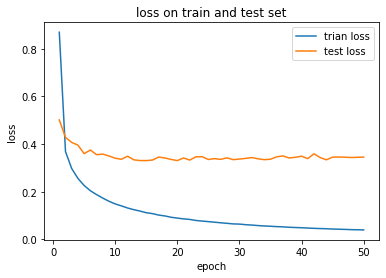

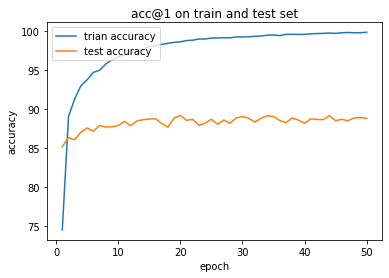

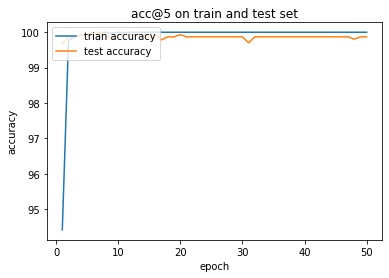

In [ ]:
acc_loss_plot(loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr)

$Results  : $

$maximum \ acc@1 \  on \  test \ set \ converges \  to  \ : \ 89.2  $%

$maximum \ acc@5 \  on \  test \ set \ converges \  to  \ : \ 99.8  $%


$maximum \ acc@1 \  on \  trian \ set \ converges \  to  \ : \ 99.86  $%

$maximum \ acc@5 \  on \  train \ set \ converges \  to  \ : \ 100  $%

---

$conclusions  : $

same as previous parts

###**part 5**
transfer learning : 
in this part we use trained weights of alexnet model that use for imagenet dataset 

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
#---description
AlexNet_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

###change last fully connected layers of this arcitecture  


In [ ]:
AlexNet_model.classifier[6] = nn.Linear(4096,15)

#---description of new model
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

###**load model**

In [ ]:
#load the model
model = AlexNet_model.to(device)

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = torch.optim.SGD(AlexNet_model.parameters(), lr=config['learning_rate'], momentum=0.9)

###**train the model**

In [ ]:
loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr=train_model(model)

Epoch [1/50], Step [94/94], Loss: 0.7481
Acc@1 of train_set: 75.69813829787235 %
Acc@1 of validation_set: 86.4025297164917 %
------------------------------
Epoch [2/50], Step [94/94], Loss: 0.2270
Acc@1 of train_set: 92.22813236967046 %
Acc@1 of validation_set: 87.1558780670166 %
------------------------------
Epoch [3/50], Step [94/94], Loss: 0.1278
Acc@1 of train_set: 95.6855791781811 %
Acc@1 of validation_set: 87.78831831614177 %
------------------------------
Epoch [4/50], Step [94/94], Loss: 0.0758
Acc@1 of train_set: 97.82062644146859 %
Acc@1 of validation_set: 88.97879473368327 %
------------------------------
Epoch [5/50], Step [94/94], Loss: 0.0448
Acc@1 of train_set: 98.90292553191489 %
Acc@1 of validation_set: 88.06733640034993 %
------------------------------
Epoch [6/50], Step [94/94], Loss: 0.0264
Acc@1 of train_set: 99.60106382978724 %
Acc@1 of validation_set: 88.09523804982503 %
------------------------------
Epoch [7/50], Step [94/94], Loss: 0.0154
Acc@1 of train_set: 

###**plot loss and accuracy**

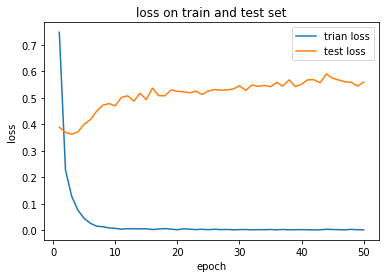

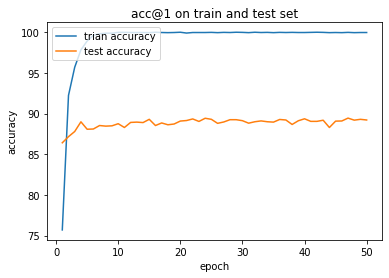

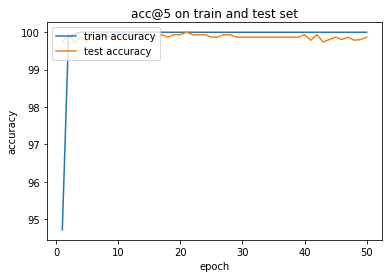

In [ ]:
acc_loss_plot(loss_te,acc1_te,acc5_te,loss_tr,acc1_tr,acc5_tr)

$Results  : $

$maximum \ acc@1 \  on \  test \ set \ converges \  to  \ : \ 89.43  $%

$maximum \ acc@5 \  on \  test \ set \ converges \  to  \ : \ 99.7  $%


$maximum \ acc@1 \  on \  trian \ set \ converges \  to  \ : \ 99.93  $%

$maximum \ acc@5 \  on \  train \ set \ converges \  to  \ : \ 100  $%

---

$conclusions  : $

same as previous parts